Binary labeled data from a pulp-and-paper mill for sheet breaks. Sheet breaks is severe problem in paper manufacturing. A single sheet break causes loss of several thousand dollars, and the mills see at least one or more break every day. This causes millions of dollors of yearly losses and work hazards.
Detecting a break event is challenging due to the nature of the process. Even 5% reduction in the breaks will bring significant benefit to the mills.

Data
18k rows collected over 15 days
The column y contains the binary labels, with 1 denoting a sheet break
The rest columns are predictors. There are about 124 positive labeled sample (~0.6%)

In [134]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)
LABELS = ["Normal", "Break"]

In [135]:
df = pd.read_csv("processminer-rare-event-mts-data.csv")

df.tail(n = 10)

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
18388,5/28/99 23:48,0,-0.842680,0.868310,-0.170921,132.747839,-0.032923,25.861885,-0.129277,0.068894,...,-0.773514,-0.752385,2.677787,0.879947,-39.785056,-1.220387,0.011754,0.777918,-0.011278,0
18389,5/28/99 23:50,0,-0.887390,0.759862,0.013136,134.416174,-0.003886,25.985024,-0.129277,0.068894,...,-0.773514,-0.752385,2.678712,2.447086,-39.665381,-0.469594,0.011754,1.296229,-0.011271,0
18390,5/28/99 23:52,0,-0.853942,0.837911,0.122202,134.416174,0.025152,26.108162,-0.129277,0.062180,...,-0.773514,-0.752385,2.679638,16.106632,-39.545691,-1.408069,0.011754,0.267405,-0.011264,0
18391,5/28/99 23:54,0,-0.866342,0.653257,0.204153,134.069434,0.054205,26.231301,-0.139347,0.058823,...,-0.773514,-0.752385,2.680563,5.617618,-39.426016,-0.219349,0.011754,0.348795,-0.011257,0
18392,5/28/99 23:56,0,-0.863607,0.735248,0.266091,133.555731,0.083242,26.922188,-0.139347,0.058823,...,-0.773514,-0.752385,2.681488,14.750553,-35.408209,-1.470630,0.009820,1.070460,-0.011249,0
18393,5/28/99 23:58,0,-0.877442,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,...,-0.773514,-0.752385,2.682413,6.944644,-37.795661,-0.860218,0.010220,0.895685,-0.011242,0
18394,5/29/99 0:00,0,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,...,-0.773514,-0.752385,2.683338,0.507755,-39.357199,-0.915699,0.010620,0.175348,-0.011235,0
18395,5/29/99 0:02,0,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,...,-0.773514,-0.752385,2.684263,2.809146,-39.357199,-1.409596,0.013323,0.621020,-0.011228,0
18396,5/29/99 0:04,0,-0.822842,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,...,-0.773514,-0.752385,2.685189,2.164859,-39.357199,-0.860218,0.012888,1.390902,-0.011221,0
18397,5/29/99 0:06,0,-0.840981,0.582710,0.593416,136.339880,0.228460,24.712960,-0.159185,0.048752,...,-0.773514,-0.752385,2.686114,1.416690,-39.357199,-0.732044,0.012453,0.418993,-0.011214,0


In [136]:
#eaach rows are of a partition of 2 minutes 
#to predict a sheet-break before it occurs. We will try to predict the break 4 minutes in advance. 
# Hence the processing is 
# if row n is positively labeled,
# Make row (n-2) and (n-1) equal to 1. This will help the classifier learn up to 4 minute ahead prediction.
# Delete row n. Because we do not want the classifier to learn predicting a break when it has happened.
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [137]:

'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))

Before shifting


,time,y,x1,x2,x3
256,5/1/99 8:32,0,1.016235,-4.058394,-1.097158
257,5/1/99 8:34,0,1.005602,-3.876199,-1.074373
258,5/1/99 8:36,0,0.933933,-3.868467,-1.249954
259,5/1/99 8:38,1,0.892311,-13.332664,-10.006578
260,5/1/99 10:50,0,0.020062,-3.987897,-1.248529


After shifting


,y,time,x1,x2,x3
255,0.0,5/1/99 8:30,0.997107,-3.865720,-1.133779
256,0.0,5/1/99 8:32,1.016235,-4.058394,-1.097158
257,1.0,5/1/99 8:34,1.005602,-3.876199,-1.074373
258,1.0,5/1/99 8:36,0.933933,-3.868467,-1.249954
260,0.0,5/1/99 10:50,0.020062,-3.987897,-1.248529


In [138]:
# drop the time, and also the categorical columns for simplicity.
df = df.drop(['time', 'x28', 'x61'], axis=1)

In [139]:
SEED = 123
DATA_SPLIT_PCT = 0.2
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

#training set 
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

#validation set 
df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

#testing set 
df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

In [140]:
#
df_train_0_stats = df_train_0.describe()
df_train_1_stats = df_train_1.describe()

print(df_train_0_stats.loc['mean'].sum())
print(df_train_1_stats.loc['mean'].sum())

423.3359775537187
186.90410983506504


In [141]:
#It is usually better to use a standardized data (transformed to Gaussian, mean 0 and variance 1) for autoencoders.
#aware that scaler fit on training data and scale separately on train, test, and valid 

scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)

df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

In [142]:
#autoencoder 
nb_epoch = 100
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3
model_file = 'autoencoder_classifier.h5'

if os.path.exists(model_file):
    autoencoder = load_model(model_file)
else:
    input_layer = Input(shape=(input_dim, ))

    encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
    encoder = Dense(hidden_dim, activation="relu")(encoder)
    decoder = Dense(hidden_dim, activation='tanh')(encoder)

    decoder = Dense(input_dim, activation='relu')(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)

    autoencoder.compile(metrics=['accuracy'],
                        loss='mean_squared_error',
                        optimizer='adam')
    cp = ModelCheckpoint(filepath= model_file,
                                   save_best_only=True,
                                   verbose=0)
    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)
    history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                        verbose=1,
                        callbacks=[cp, tb]).history

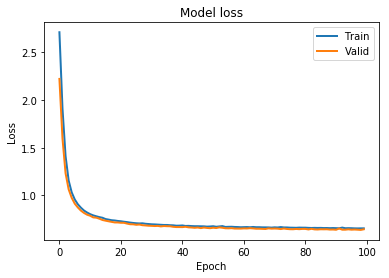

In [143]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

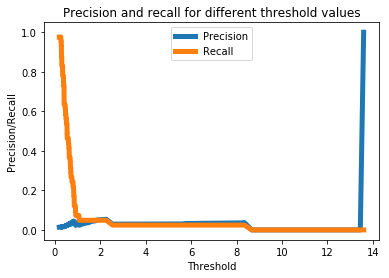

In [144]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [145]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()

0.1424427225090402
13.5513612304067


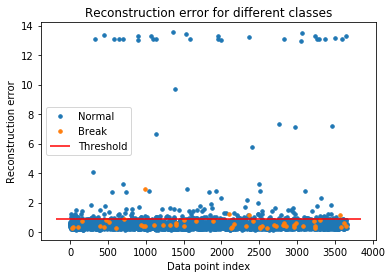

In [146]:
print(np.amin(mse))
print(np.amax(mse))

threshold_fixed = 0.85
groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


In [147]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

In [148]:
predictions = pd.DataFrame({'true': error_df.True_class,
                           'predicted': pred_y})

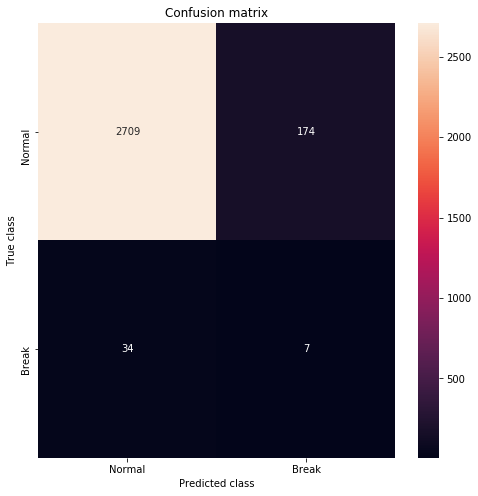

In [149]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

'''
We could predict 9 out of 32 breaks instances. 
Note that these instances include 2 or 4 minute ahead predictions. 
This is around 28%, which is a good recall rate for the paper industry. 
The False Positive Rate is around 6.3%. This is not ideal but not terrible for a mill.
'''

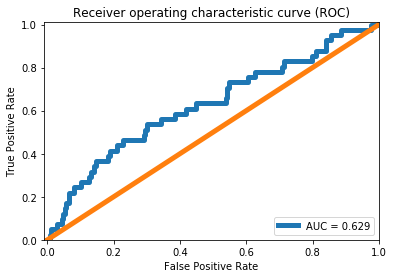

In [150]:

false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()